Below code for the research paper  <br>
Paper Title : An Ensemble Approach for Feature Selection and Classification in Intrusion Detection Using Extra-Tree Algorithm <br>
Journal : International Journal Information Security Privacy <br>
Volume: 16 <br>
Number:  1 <br>
Article: 13 <br>
PP: 1-21 <br>
ISSN: 1930-1650 <br>
ISSN (Online): 1930-1669 <br>
DOI: 10.4018/IJISP.2022010113 <br>
Author : 1) Ankit Kharwar 2) Devendra Thakor  

In [1]:
# import basic packge like pandas, numpy and sklearn
import pandas as pd
import numpy as np
import sys
import sklearn

# Display the version of the packge
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

1.3.5
1.21.6
3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
1.0.2


In [2]:
# if you run on google cloab with google drive the below code is required and give the permission to the google drive by login
# if you run on your computer then you can skip upto 3 steps
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# after the given permission to access the google drive. take the parth of folder you want to acccess for the training and testing file
file_list = drive.ListFile({'q': "' HERE  ' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

In [4]:
#list of all the file in the the above folder mention.
# take the id of that file you want to you for training and tesing and give the name as train.csv and test.csv
train_downloaded = drive.CreateFile({'id': ' ID of Traning data '})

train_downloaded.GetContentFile('train.csv')
test_downloaded = drive.CreateFile({'id': ' ID of Testing data'})

test_downloaded.GetContentFile('test.csv')


# Data Reading 


In [5]:
# col name of the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","a1"]

# if you don't use google colab then directly give the parth of the file at time of read csv
df = pd.read_csv("train.csv", header=None, names = col_names)
df_test = pd.read_csv("test.csv", header=None, names = col_names)

#drop extra column from the dataset
df=df.drop(columns=['a1'])
df_test=df_test.drop(columns=['a1'])

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (25192, 42)
Dimensions of the Test set: (22544, 42)


In [6]:
#display first five record from dataset
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


# Data Preprocessing 


1.   Remove Duplicate Row
2.   Relabeling the label
3.   Label Encoding

In [7]:
#remove duplicate data from training and testing and display the before and after the removing duplicate records
print("Before Processing of training data",df.shape)
df.drop_duplicates(keep=False,inplace=True) 
print("After Processing of training data", df.shape)
print("Before Processing of testing data",df_test.shape)
df_test.drop_duplicates(keep=False,inplace=True) 
print("After Processing of testing data", df_test.shape)

Before Processing of training data (25192, 42)
After Processing of training data (25192, 42)
Before Processing of testing data (22544, 42)
After Processing of testing data (22544, 42)


In [8]:
# take label column 
labeldf=df['label']
labeldf_test=df_test['label']

# relabing the attack column. 
#convert the subcategories of attack into the main attack
# 0 means normal 
# 1 means Dos Attack
# 2 means Probe attack
# 3 means R2L attack
# 4 means U2R attack

newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})

# put the new label column back in the dataset
df['label'] = newlabeldf
df_test['label'] = newlabeldf_test

# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables

X_df = df.drop('label',1)
Y_df = df.label
# test set
X_df_test = df_test.drop('label',1)
Y_df_test = df_test.label

# reshape the label for training and testing
Y_df.values.reshape(-1)
Y_df_test.values.reshape(-1)

# apply label encoder (convert categorical data to numerical data)
from sklearn.preprocessing import LabelEncoder

X_df= X_df.apply(LabelEncoder().fit_transform)
X_df_test= X_df_test.apply(LabelEncoder().fit_transform)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [9]:
# attack distribution on training and testing dataset.
print('Label distribution of Training set:')
print(df['label'].value_counts())
print()
print('Label distribution of Test set:')
print(df_test['label'].value_counts())

Label distribution of Training set:
0    13449
1     9234
2     2289
3      209
4       11
Name: label, dtype: int64

Label distribution of Test set:
0    9711
1    7460
3    2885
2    2421
4      67
Name: label, dtype: int64


# Feature Selection

In [10]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import time
import random
from sklearn.ensemble import ExtraTreesClassifier


# use extra-tree classification and find the best paramater for the classification using grid search
fit_et = ExtraTreesClassifier(random_state=42)

np.random.seed(42)
# calculate the time for grid search
start = time.time()

# select the paramater you want to optimize 
param_dist = {'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}
               
cv_et = GridSearchCV(fit_et, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 10)

cv_et.fit(X_df, Y_df)
print('Best Parameters using grid search: \n', cv_et.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': False, 'criterion': 'entropy'}
Time taken in grid search:  35.39


In [11]:
# Set best parameters given by grid search
d={}
d=cv_et.best_params_
fit_et.set_params(bootstrap= str(d['bootstrap']), criterion= d['criterion'])

ExtraTreesClassifier(bootstrap='False', criterion='entropy', random_state=42)

In [12]:
# find out best estimator using oob (out of bag)
fit_et.set_params(warm_start=True, 
                  oob_score=True)
print(fit_et)
error_rate = {}

for i in range(500,10000+1, 500):
    fit_et.set_params(n_estimators=i)
    print("Estimator",i)
    fit_et.fit(X_df, Y_df)

    oob_error = 1 - fit_et.oob_score_
    error_rate[i] = oob_error
    print("OOB_Error", oob_error)
    

ExtraTreesClassifier(bootstrap='False', criterion='entropy', oob_score=True,
                     random_state=42, warm_start=True)
Estimator 500
OOB_Error 0.0028183550333439333
Estimator 1000
OOB_Error 0.002937440457288054
Estimator 1500
OOB_Error 0.002977135598602687
Estimator 2000
OOB_Error 0.003016830739917431
Estimator 2500
OOB_Error 0.002937440457288054
Estimator 3000
OOB_Error 0.002937440457288054
Estimator 3500
OOB_Error 0.002937440457288054
Estimator 4000
OOB_Error 0.002937440457288054
Estimator 4500
OOB_Error 0.002937440457288054
Estimator 5000
OOB_Error 0.002937440457288054
Estimator 5500
OOB_Error 0.002937440457288054
Estimator 6000
OOB_Error 0.00289774531597331
Estimator 6500
OOB_Error 0.002937440457288054
Estimator 7000
OOB_Error 0.002977135598602687
Estimator 7500
OOB_Error 0.002937440457288054
Estimator 8000
OOB_Error 0.002977135598602687
Estimator 8500
OOB_Error 0.002937440457288054
Estimator 9000
OOB_Error 0.002937440457288054
Estimator 9500
OOB_Error 0.00293744045728

In [13]:
# minium oob wil give the best estimator 
# take min oob and find the estimator from above list 
oob_series = pd.Series(error_rate)
print("min error", min(oob_series))

print("best estimator",oob_series.idxmin())   

min error 0.0028183550333439333
best estimator 500


In [19]:
# take the best paramater and given to extra-tree
clf = ExtraTreesClassifier(oob_series.idxmin(), criterion = d['criterion'],
                  bootstrap=str(d['bootstrap']), n_jobs=-1)

# Train the data with classifier
clf.fit(X_df, Y_df)

F=zip(col_names, clf.feature_importances_)

# Print the name of the feature and feature importance 
for feature in zip(col_names, clf.feature_importances_):
    print(feature)


('duration', 0.004566696990248308)
('protocol_type', 0.03790093556059792)
('service', 0.022743475135950136)
('flag', 0.04617937648765082)
('src_bytes', 0.04245766081824907)
('dst_bytes', 0.020054295414923633)
('land', 5.1361998426938956e-05)
('wrong_fragment', 0.015748292143306128)
('urgent', 7.46423272901084e-05)
('hot', 0.009772928430880002)
('num_failed_logins', 0.0005162337933788047)
('logged_in', 0.06460178559921632)
('num_compromised', 0.005329773023138757)
('root_shell', 0.000580002197630211)
('su_attempted', 3.5493540288529845e-05)
('num_root', 0.00043578947245571904)
('num_file_creations', 0.00037453143333332245)
('num_shells', 3.714530401860297e-05)
('num_access_files', 0.00017761168084868948)
('num_outbound_cmds', 0.0)
('is_host_login', 0.0)
('is_guest_login', 0.002900362620834109)
('count', 0.036344218803074126)
('srv_count', 0.020209840116554748)
('serror_rate', 0.06297228593221964)
('srv_serror_rate', 0.058642633117128605)
('rerror_rate', 0.019777257037132887)
('srv_rerro

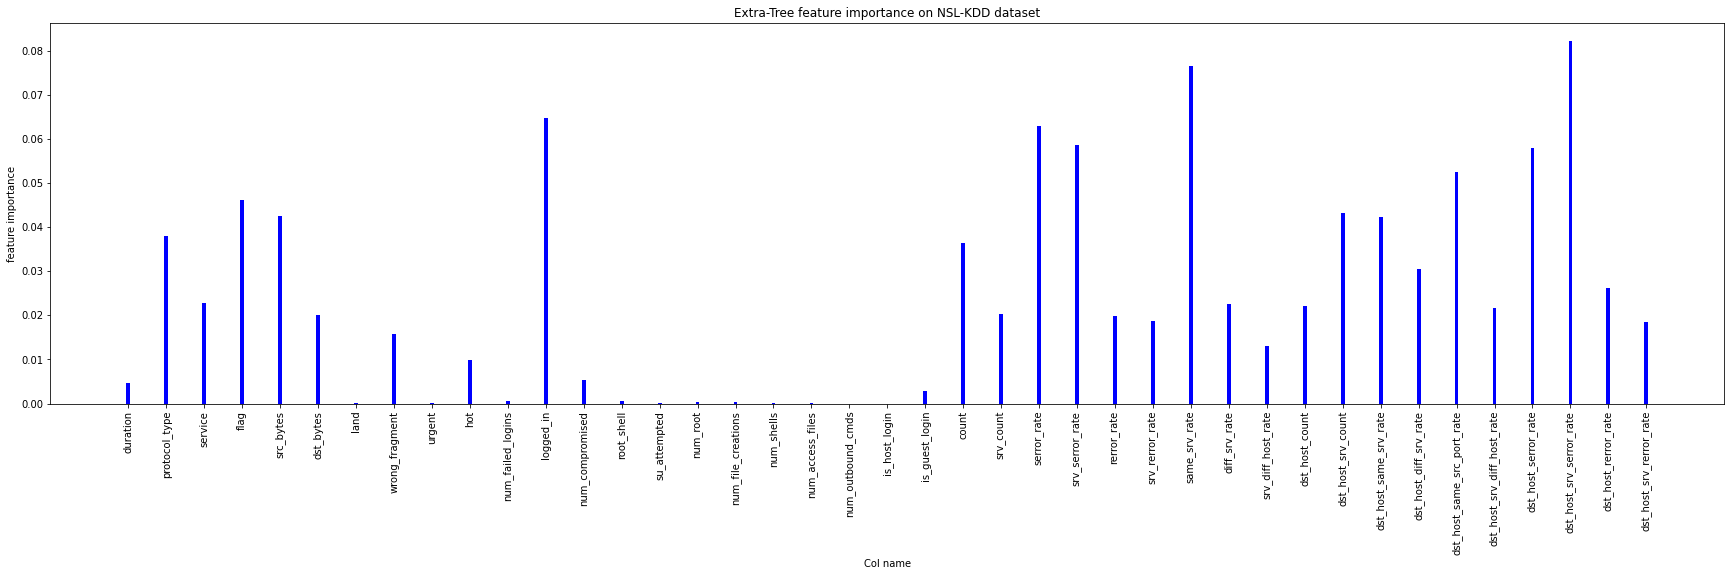

In [20]:
import matplotlib.pyplot as plt
 
  
# Feature importance range between 0 to 1

fig = plt.figure(figsize = (30, 7))
COL, FI = zip(*F)
# creating the bar plot
plt.bar(COL, FI, color ='blue', width = 0.1)
plt.xticks(COL, COL, rotation=90)

plt.xlabel("Col name")
plt.ylabel("feature importance")
plt.title("Extra-Tree feature importance on NSL-KDD dataset")
plt.show()


In [21]:
# Extra-Tree classification is used for measure the accuracy while increasing the threshold so it elimate feature below the threshold

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y=0
acc={}

#list of threshold
iterate_list = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.011,0.012,0.013,0.014,0.015,0.016,0.017,0.018,0.019,0.02,0.021,0.022,0.023,0.024,0.025,0.026,0.027,0.028,0.029,0.03,0.031,0.032,0.033,0.034,0.035,0.036,0.037,0.038,0.039,
                0.04,0.041,0.042,0.043,0.044]
# take one by one threshold and find the feature above the threshold and calculate the accuracy using extra-tree
for j in iterate_list:
  print("threshold is ",j)
  # Create a selector object that will use the Extra-Tre classifier to identify
  sfm = SelectFromModel(clf, threshold=j)   

  # Train the selector
  sfm.fit(X_df, Y_df)

  # Print the names of the most important features

  l=[]
  for feature_list_index in sfm.get_support(indices=True):
      l.append(col_names[feature_list_index])

  print(l)
  print("no of feature",len(l))
  Selected_features = l
  fe=len(l)
  # if feature length is not same while increasing the threshold then calculate new feature 
  if(y!=fe):
    y=fe 
    # take only feature that will taken and given to X_rfedf and X_rfedf_test
    X_rfedf = X_df[Selected_features]
    X_rfedf_test = X_df_test[Selected_features]

    # calcuate the accuracy on given feature 
    fit_et = ExtraTreesClassifier(n_jobs=10)
    fit_et.fit(X_rfedf, Y_df)
    y_pred = fit_et.predict(X_rfedf_test)
    print("accuracy",accuracy_score(Y_df_test, y_pred))
    acc[j]=accuracy_score(Y_df_test, y_pred)
  # if feature length is same while increasing the threshold then no need to calculate again for that feature
  else:
    print("Same feature as ",y)   

threshold is  0.001
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
no of feature 30
accuracy 0.7402413058907026
threshold is  0.002
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',

In [22]:
# find maximum accuracy on which threshold 
th = max(zip(acc.values(), acc.keys()))[1]
print("Threshold with max accuracy",th)

Threshold with max accuracy 0.005


In [23]:
# take the best feature from above threshold value an replace below list 
Selected_features =['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

# take the only above feature data
X_rfedf = X_df[Selected_features]
X_rfedf_test = X_df_test[Selected_features]


# Classification

In [24]:
# apply Extra-Tree algorithm for best selected feature using Extra-Tree importance
# find the best hyper-parameter for Extra-Tree

fit_et = ExtraTreesClassifier(random_state=42)

np.random.seed(42)
start = time.time()

param_dist = {'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}
               
cv_et = GridSearchCV(fit_et, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv_et.fit(X_rfedf, Y_df)
print('Best Parameters using grid search: \n', 
      cv_et.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': False, 'criterion': 'entropy'}
Time taken in grid search:  28.02


In [25]:
# Set best parameters given by grid search 
d={}
d=cv_et.best_params_
fit_et.set_params(bootstrap= str(d['bootstrap']), criterion= d['criterion'])

ExtraTreesClassifier(bootstrap='False', criterion='entropy', random_state=42)

In [26]:
fit_et.set_params(warm_start=True, 
                  oob_score=True)

error_rate = {}

for i in range(500,10000+1, 500):
    fit_et.set_params(n_estimators=i)
    print(i)
    fit_et.fit(X_rfedf_test, Y_df_test)

    oob_error = 1 - fit_et.oob_score_
    error_rate[i] = oob_error
    print(oob_error)

500
0.016811568488289574
1000
0.01627927608232793
1500
0.016545422285308753
2000
0.01645670688431511
2500
0.016190560681334287
3000
0.016190560681334287
3500
0.01627927608232793
4000
0.01623491838183111
4500
0.016190560681334287
5000
0.016323633782824754
5500
0.01623491838183111
6000
0.016101845280340643
6500
0.016323633782824754
7000
0.01623491838183111
7500
0.016190560681334287
8000
0.01623491838183111
8500
0.01627927608232793
9000
0.01627927608232793
9500
0.016323633782824754
10000
0.016367991483321465


In [27]:
oob_series = pd.Series(error_rate)
print("min error", min(oob_series))

print("best estimator",oob_series.idxmin())   

min error 0.016101845280340643
best estimator 6000


In [30]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Train the the Classification with the best hyper-parameter and run with the best feature 

bdt= ExtraTreesClassifier(n_estimators=oob_series.idxmin(),bootstrap= str(d['bootstrap']), criterion= d['criterion'])
# train the the model
bdt.fit(X_rfedf, Y_df)

# training and testing accuracy score
y_pred_train = bdt.predict(X_rfedf)
y_pred_test = bdt.predict(X_rfedf_test)

accuracy_train = accuracy_score(Y_df, y_pred_train)
accuracy_test = accuracy_score(Y_df_test, y_pred_test)

print("Training accuracy: %.4f" % accuracy_train)
print("Testing accuracy:  %.4f" % accuracy_test)


# apply 10-cross fold valdiation and print confusion_matrix

y_pred_cv = cross_val_predict(bdt, X_rfedf_test, Y_df_test, cv=10,verbose=2,n_jobs=10 )
accuracy_test = accuracy_score(Y_df_test, y_pred_cv)
print("CV Testing accuracy:  %.4f" % accuracy_test)
conf_mat = confusion_matrix(Y_df_test, y_pred_cv)
print(conf_mat)
n_rf=round((conf_mat[0][0]/conf_mat[0].sum())*100,2)
print('Detection rate of Normal',n_rf)
d_rf=round((conf_mat[1][1]/conf_mat[1].sum())*100,2)
print('Detection rate of DOS',d_rf)
d_rf=round((conf_mat[2][2]/conf_mat[2].sum())*100,2)
print('Detection rate of Prob',d_rf)
d_rf=round((conf_mat[3][3]/conf_mat[3].sum())*100,2)
print('Detection rate of R2L',d_rf)
d_rf=round((conf_mat[4][4]/conf_mat[4].sum())*100,2)
print('Detection rate of U2R',d_rf)

print(classification_report(Y_df_test, y_pred_cv))




Training accuracy: 1.0000
Testing accuracy:  0.7443


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:  3.2min remaining:  7.6min


CV Testing accuracy:  0.9838
[[9573   16   11  107    4]
 [  19 7438    3    0    0]
 [  30    1 2388    2    0]
 [ 134    2    0 2743    6]
 [  13    0    0   18   36]]
Detection rate of Normal 98.58
Detection rate of DOS 99.71
Detection rate of Prob 98.64
Detection rate of R2L 95.08
Detection rate of U2R 53.73
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      9711
           1       1.00      1.00      1.00      7460
           2       0.99      0.99      0.99      2421
           3       0.96      0.95      0.95      2885
           4       0.78      0.54      0.64        67

    accuracy                           0.98     22544
   macro avg       0.94      0.89      0.91     22544
weighted avg       0.98      0.98      0.98     22544



[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  6.4min finished


In [31]:
# convert into 2 lable for finding of the False alarm rate and detetion rate of the Extra-Tree model with best feature
# First 0 means normal and 1 means attack then interchange with 0 means attack and 1 means normal in y_df2

Y_df1 = Y_df.copy()
Y_df1[Y_df1!=0] = 1
Y_df2 = Y_df1.copy()
Y_df2[Y_df2==0] = 100
Y_df2[Y_df2!=100] = 0
Y_df2[Y_df2==100] = 1

Y_df_test1 = Y_df_test.copy()
Y_df_test1[Y_df_test1!=0] = 1
Y_df_test2 = Y_df_test1.copy()
Y_df_test2[Y_df_test2==0] = 100
Y_df_test2[Y_df_test2!=100] = 0
Y_df_test2[Y_df_test2==100] = 1




In [32]:
print('Label distribution Training set:')
print(Y_df2.value_counts())
print()
print('Label distribution Test set:')
print(Y_df_test2.value_counts())



Label distribution Training set:
1    13449
0    11743
Name: label, dtype: int64

Label distribution Test set:
0    12833
1     9711
Name: label, dtype: int64


In [34]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import time
import random
from sklearn.ensemble import ExtraTreesClassifier


# train the with binary classfiication and find best feature 
fit_et = ExtraTreesClassifier(random_state=42)

np.random.seed(42)
start = time.time()

param_dist = {'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}
               
cv_et = GridSearchCV(fit_et, cv = 10,
                     param_grid=param_dist, verbose=3,scoring='accuracy',
                     n_jobs = 10)

cv_et.fit(X_rfedf, Y_df2)
print('Best Parameters using grid search: \n', 
      cv_et.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Parameters using grid search: 
 {'bootstrap': False, 'criterion': 'gini'}
Time taken in grid search:  27.45


In [35]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import time
import random
from sklearn.ensemble import ExtraTreesClassifier

# Set best parameters given by above grid search 

d={}
d=cv_et.best_params_

fit_et = ExtraTreesClassifier(random_state=42,bootstrap= str(d['bootstrap']), criterion= d['criterion'])

np.random.seed(42)
start = time.time()

# find the best n_estimators using grid search
param_dist = {'n_estimators': [2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000]}
               
cv_et = GridSearchCV(fit_et, cv = 10,
                     param_grid=param_dist, verbose=3,scoring='accuracy',
                     n_jobs = 10)

cv_et.fit(X_rfedf, Y_df2)
print('Best Parameters using grid search: \n', 
      cv_et.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Fitting 10 folds for each of 17 candidates, totalling 170 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best Parameters using grid search: 
 {'n_estimators': 2000}
Time taken in grid search:  6352.76


In [36]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


d1={}
d1=cv_et.best_params_
# given the all the best paramater to Extra-Tree
bdt= ExtraTreesClassifier(n_estimators=d1['n_estimators'],bootstrap= str(d['bootstrap']), criterion= d['criterion'],n_jobs=10)
                          

bdt.fit(X_rfedf, Y_df2)
y_pred_train = bdt.predict(X_rfedf)
y_pred_test = bdt.predict(X_rfedf_test)

accuracy_train = accuracy_score(Y_df2, y_pred_train)
accuracy_test = accuracy_score(Y_df_test1, y_pred_test)

print("Training accuracy: %.4f" % accuracy_train)
print("Testing accuracy:  %.4f" % accuracy_test)


#10-cross validation and print confusion matrix and other paramater

y_pred_cv = cross_val_predict(bdt, X_rfedf_test, Y_df_test2, cv=10,verbose=2,n_jobs=100 )
accuracy_test = accuracy_score(Y_df_test2, y_pred_cv)
print(classification_report(Y_df_test2, y_pred_cv))

print("CV Testing accuracy:  %.4f" % accuracy_test)
conf_mat = confusion_matrix(Y_df_test2, y_pred_cv)
print(conf_mat)
n_rf=round((conf_mat[0][0]/conf_mat[0].sum())*100,2)
print('Detection rate of Attack',n_rf)
d_rf=round((conf_mat[1][1]/conf_mat[1].sum())*100,2)
print('Detection rate of Normal',d_rf)

print(classification_report(Y_df_test2, y_pred_cv))

print("False alarm rate (FAR)")
far=conf_mat[1][0]/(conf_mat[1][0]+conf_mat[1][1])
print(far*100)

Training accuracy: 1.0000
Testing accuracy:  0.2270


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   3 out of  10 | elapsed:  1.1min remaining:  2.6min
[Parallel(n_jobs=100)]: Done  10 out of  10 | elapsed:  2.4min finished


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12833
           1       0.98      0.98      0.98      9711

    accuracy                           0.99     22544
   macro avg       0.98      0.99      0.98     22544
weighted avg       0.99      0.99      0.99     22544

CV Testing accuracy:  0.9853
[[12661   172]
 [  160  9551]]
Detection rate of Attack 98.66
Detection rate of Normal 98.35
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12833
           1       0.98      0.98      0.98      9711

    accuracy                           0.99     22544
   macro avg       0.98      0.99      0.98     22544
weighted avg       0.99      0.99      0.99     22544

False alarm rate (FAR)
1.6476161054474308
